<a href="https://colab.research.google.com/github/cstorm125/diy_covid/blob/master/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Do Not) Do-It-Yourself COVID-19 "Data Scientist" Kit 

This notebook offers a drag-and-drop interface for polynomial and exponential curve fitting that will allow you to predict COVID-19 cases in Thailand like a "data scientist" with just some hyperparameter tuning, and why you should or should not do it.

## Imports

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from functools import partial
import matplotlib.pyplot as plt
from plotnine import *
from mizani.formatters import *

def poly_func(x, *coefs):
  return sum([coefs[i] * x**i for i in range(len(coefs))])

def exp_func(x, b0, b1, b2):
    return b0 * np.exp(b1 * x) + b2

def get_prediction(func, cutting_point=33, nb_coefs = 3, valid_interval=5, show_plot=True):
  x_train = np.array(th.index[:cutting_point+1])
  y_train = np.array(th.total_cases[:cutting_point+1])
  x_valid = np.array(th.index[cutting_point:])
  y_valid = np.array(th.total_cases[cutting_point:])

  coefs, _ = curve_fit(func, x_train, y_train, p0=np.ones(nb_coefs))
  y_pred = np.array([func(i,*coefs) for i in x_valid])
  y_fit = np.array([func(i,*coefs) for i in x_train])
  
  if show_plot:
    print(f'Total MSE: {np.mean((y_pred-y_valid)**2):.2f}; Total MAPE: {100*np.mean(abs(y_pred-y_valid)/y_valid):.2f}%')
    print(f'{valid_interval}-day MSE: {np.mean((y_pred[:valid_interval]-y_valid[:valid_interval])**2):.2f}; {valid_interval}-day MAPE: {np.mean(abs(y_pred[:valid_interval]-y_valid[:valid_interval])/y_valid[:valid_interval]):.2f}%')
    plot_df = pd.DataFrame({'day':np.concatenate([x_train,x_valid]),
                            'prediction':np.concatenate([y_fit,y_pred]),
                            'ground_truth':np.concatenate([y_train,y_valid])}).melt(id_vars='day')
    g = (ggplot(plot_df,aes(x='day',y='value',color='variable')) + geom_line() +
        geom_vline(xintercept=cutting_point,linetype="dashed") + theme_minimal()+
        annotate(geom="text", x=cutting_point-10,y=500, label='Training Peroid') +
        annotate(geom="text", x=cutting_point+10,y=500, label='Prediction Peroid') +
        coord_cartesian(xlim=(0,50))+
        ylab('Total Cases') + xlab('Days Since First Case'))
    g.draw()
  
    # plt.plot(x_train,y_train)
    # plt.plot(x_valid,y_valid)
    # plt.plot(x_train,y_fit)
    # plt.plot(x_valid,y_pred)

  return np.mean((y_pred-y_valid)**2), np.mean(abs(y_pred-y_valid)/y_valid), \
    np.mean((y_pred[:valid_interval]-y_valid[:valid_interval])**2), \
    np.mean(abs(y_pred[:valid_interval]-y_valid[:valid_interval])/y_valid[:valid_interval])

# Data



We use Thailand data from [Our World In Data](https://ourworldindata.org/coronavirus-source-data) which contains number of cases and deaths from COVID-19.

In [300]:
df = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
th = df[df.location=='Thailand'].tail(40).reset_index(drop=True).reset_index()
th.tail()

,index,date,location,new_cases,new_deaths,total_cases,total_deaths
35,35,2020-03-24,Thailand,106,3,827,4
36,36,2020-03-25,Thailand,107,0,934,4
37,37,2020-03-26,Thailand,111,0,1045,4
38,38,2020-03-27,Thailand,91,1,1136,5
39,39,2020-03-28,Thailand,0,0,1136,5


## You Can Fit ANY Curve

Use the widgets below to finetune how many days you want to include in your model training (and effectively how many days you want to predict) and some hyperparameters, then *※magic※* you are now making predictions like a "data scientist". 

Shoutout to this [stackoverflow thread](https://stackoverflow.com/questions/50727723/curve-fit-with-polynomials-of-variable-length) that shows how to do `scipy.optimize` for functions with variable length of input.

### Polynomial Curves

Total MSE: 50090.79; Total MAPE: 24.75%
5-day MSE: 53118.40; 5-day MAPE: 0.28%


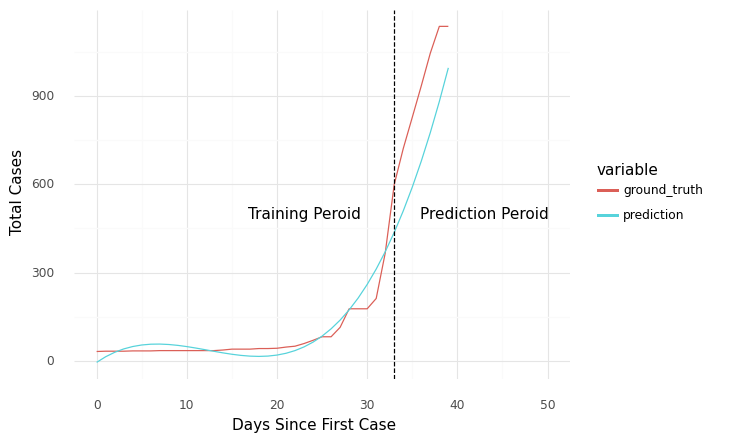

In [293]:
#@title {run: "auto"}
cutting_point = 33 #@param {type:"slider", min:25, max:35, step:1}
nb_coefs = 4 #@param {type:"slider", min:1, max:7, step:1}
get_prediction(poly_func,cutting_point=cutting_point,nb_coefs=nb_coefs);

### Exponential Curves

Total MSE: 122366.30; Total MAPE: 23.97%
5-day MSE: 1199.51; 5-day MAPE: 0.16%


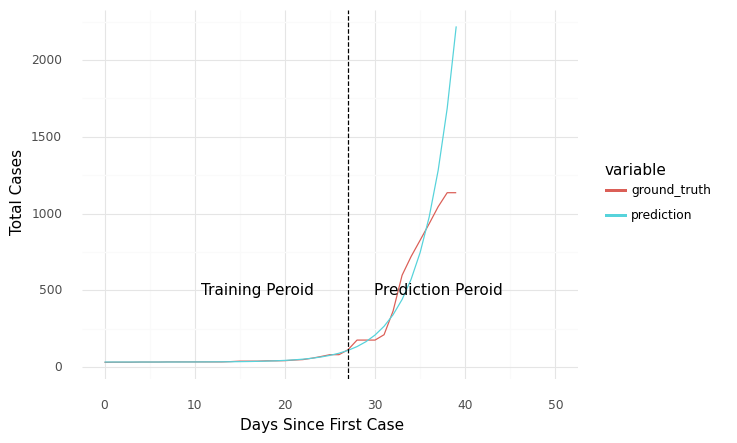

In [299]:
#@title {run: "auto"}
cutting_point = 27 #@param {type:"slider", min:25, max:35, step:1}
get_prediction(exp_func,cutting_point=cutting_point,nb_coefs=3);

## Why This Is A Terrible Idea To Predict From 30 Data Points

It is great we have such tools and data that allow us to do some fun predictions but let us see why curve fitting with very few data points (25-35 to be exact) is a terrible idea. Let us take the period where the number of total cases starts to look like an exponential curve:

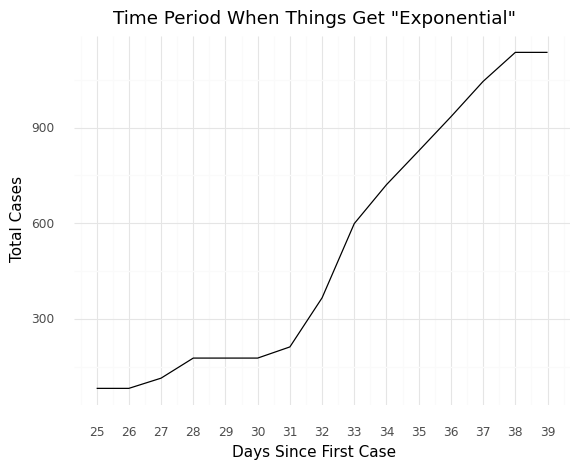

<ggplot: (8737988022543)>

In [297]:
g = (ggplot(th.iloc[25:,[0,5]], aes(x='index',y='total_cases',group=1))+
     geom_line() + theme_minimal() +
     ggtitle('Time Period When Things Get "Exponential"') +
     scale_x_continuous(breaks=[i for i in range(40)])+
     theme(legend_title = element_blank())+
     xlab('Days Since First Case') + ylab('Total Cases'))
g

Now remember we have 2 main hyperparameters to tweak:
1. Models: polynomial (at what number of coefficients) or exponential
2. Number of days used to train

Let us say we use mean absolute percentage error (MAPE) for predictions in the next 5 days as our model error rates, we arrive at the following plot:

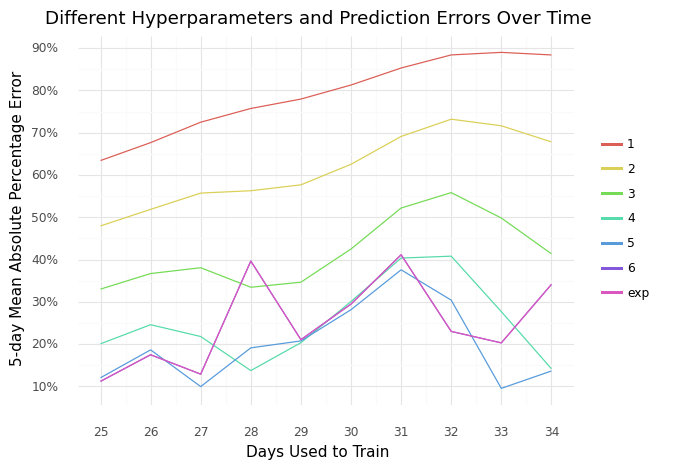

<ggplot: (8738000197012)>

In [248]:
results = []
for cp in range(25,35):
  for nb in range(1,7):
    result = get_prediction(poly_func,cp,nb,5,False)
    results.append({'cutting_point':cp, 'nb_coefs':nb, 'mse': result[2], 'mape': result[3]})
  exp_result = get_prediction(exp_func,cp,3,5,False)
  results.append({'cutting_point':cp, 'nb_coefs':'exp', 'mse': result[2], 'mape': result[3]})
result_df = pd.DataFrame(results)

g = (ggplot(result_df, aes(x='cutting_point',y='mape',
     group='nb_coefs',color='factor(nb_coefs)')) + 
     geom_line() + theme_minimal() +
     ggtitle('Different Hyperparameters and Prediction Errors Over Time') +
     scale_y_continuous(labels=percent_format(), breaks=[i/10 for i in range(10)])+
     scale_x_continuous(breaks=[i for i in range(40)])+
     theme(legend_title = element_blank())+
     xlab('Days Used to Train') + ylab('5-day Mean Absolute Percentage Error'))
g

Clearly, polynomial curves with one coefficient (aka a flat line) or two coefficients (aka a straight line) are reliably bad with MAPE of over 50% over all number of days used to trained. But more importantly, even if you look at models which do reasonably well such as polynomial with 4, 5 and 6 coefficients, and the exponential curve, you can see that these models have quite large variance in their performance with range from 10% up to 40% MAPE.

At no point in time is one model "the best" for this prediction. This is to be expected since:
1. We have very few training data points
2. What we are trying to predict has a very dynamic nature
3. We do not have any means to obtain the features that might describe that dynamic nature

Now then, if you are now asking yourself:

> Why are we trying to apply statistical modeling (machine learning) to the ONE situation where we are taught in every single textbook that it is not suitable for? 

Then I have accomplished my goal with this notebook.
